Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

Getting the data

In [2]:
df=pd.read_excel('Online Retail.xlsx')

**Data Preprocessing**

In [3]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
df.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID Country  
541904 2011-12-09 12:50:00       0.85     12680.0  France  
541905 2011-12-09 12:50:00       2.10     12680.0  France  
541906 2011-12-09 12:50:00       4.15     12680.0  France  
541907 2011-12-09 12:50:00       4.15     12680.0  France  
541908 2011-12-09 12:50:00       4.95     12680.0  France

In [5]:

total_rows = df.shape[0]
print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 541909


In [6]:
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [7]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

The above cell shows that the 'Quantity' and 'UnitPrice' columns have negative values

In [8]:
def descr(df):
    no_rows = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    nan_percent = (df.isnull().sum() / no_rows) * 100
    skewness = df.skew(numeric_only=True)
    kurtosis = df.kurt(numeric_only=True)

    cols = {
        'dtypes': types, 
        'counts': counts, 
        'distincts': distincts, 
        'nulls': nulls,  
        'missing_percent': nan_percent, 
        'uniques': uniques, 
        'skewness': skewness, 
        'kurtosis': kurtosis
    }
    
    table = pd.DataFrame(data=cols)
    return table

details = descr(df)

display(details.sort_values(by='missing_percent', ascending=False))


dtypes  counts  distincts   nulls  missing_percent  \
CustomerID          float64  406829       4373  135080        24.926694   
Description          object  540455       4224    1454         0.268311   
Country              object  541909         38       0         0.000000   
InvoiceDate  datetime64[ns]  541909      23260       0         0.000000   
InvoiceNo            object  541909      25900       0         0.000000   
Quantity              int64  541909        722       0         0.000000   
StockCode            object  541909       4070       0         0.000000   
UnitPrice           float64  541909       1630       0         0.000000   

                                                       uniques    skewness  \
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.029835   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
Country      [United Kingdom, France, Australia, Netherland...         NaN   
InvoiceDate  [2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...         NaN   
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...   -0.264076   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  186.506972   

                  kurtosis  
CustomerID       -1.179982  
Description            NaN  
Country                NaN  
InvoiceDate            NaN  
InvoiceNo              NaN  
Quantity     119769.160031  
StockCode              NaN  
UnitPrice     59005.719097

This overview highlights potential areas of concern, such as missing data in CustomerID(~25%) and extreme values (outliers) in Quantity and UnitPrice.

**Data Cleaning**

Finding out where all the negative and values are present

In [9]:
print("Number of rows where negative values are present : ", 
      df[(df['Quantity']<0) | (df['UnitPrice']<0)].shape[0])

print("\nAre negative values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<0) & (df['UnitPrice']<0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("\nAre negative or 0 values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<=0) & (df['UnitPrice']<=0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("What is the customer ID of such rows :",
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), ['CustomerID']].CustomerID.unique())

Number of rows where negative values are present :  10626

Are negative values in both Quantity and UnitPrice present in same row : No

Are negative or 0 values in both Quantity and UnitPrice present in same row : Yes
What is the customer ID of such rows : [nan]


In [10]:
print("Invoice Numbers of rows with quantity having negative values : ") 
print(df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with quantity having negative values : 
141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 8905, dtype: object

All the Invoice Numbers start with :  ['C']


In [11]:
print("Invoice Numbers of rows with UnitPrice having negative values : ") 
display(df[(df.UnitPrice<0) & (df.CustomerID.isnull())])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice<0) & (df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print("\nInvoice Numbers of rows with UnitPrice having 0 values : ") 
display(df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].head(10))
print("Total number of rows : ", df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].shape[0])


Invoice Numbers of rows with UnitPrice having negative values : 


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom


All the Invoice Numbers start with :  ['A']

Invoice Numbers of rows with UnitPrice having 0 values : 


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom

Total number of rows :  40


Handling the outliers by IQR

In [12]:
df = df[~df.CustomerID.isnull()]
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

df = df.drop_duplicates(subset=['InvoiceNo', 'CustomerID', 'StockCode'], keep='first')

Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
df = df[(df['Quantity'] >= (Q1_quantity - 1.5 * IQR_quantity)) & (df['Quantity'] <= (Q3_quantity + 1.5 * IQR_quantity))]

Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
df = df[(df['UnitPrice'] >= (Q1_price - 1.5 * IQR_price)) & (df['UnitPrice'] <= (Q3_price + 1.5 * IQR_price))]

df.reset_index(drop=True, inplace=True)

details = df.describe()
distincts = df.nunique()  
details = details.T  
details['distincts'] = distincts  
display(details.sort_values(by='distincts', ascending=False))


count                           mean                  min  \
InvoiceDate    328570  2011-07-12 05:33:00.356453376  2010-12-01 08:26:00   
CustomerID   328570.0                   15312.776988              12347.0   
UnitPrice    328570.0                        2.20016                0.001   
Quantity     328570.0                       7.607076                  1.0   

                             25%                  50%                  75%  \
InvoiceDate  2011-04-08 09:08:00  2011-08-02 14:04:00  2011-10-21 13:17:00   
CustomerID               13983.0              15215.0              16813.0   
UnitPrice                   1.25                 1.65                 2.95   
Quantity                     2.0                  6.0                 12.0   

                             max          std  distincts  
InvoiceDate  2011-12-09 12:50:00          NaN      15782  
CustomerID               18287.0  1711.661677       4191  
UnitPrice                    7.5     1.548492        182  
Quantity                    27.0     6.793858         27

Here, we have removed all null and negative values from dataset

In [13]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  328570.000000                         328570  328570.000000   
mean        7.607076  2011-07-12 05:33:00.356453376       2.200160   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-08 09:08:00       1.250000   
50%         6.000000            2011-08-02 14:04:00       1.650000   
75%        12.000000            2011-10-21 13:17:00       2.950000   
max        27.000000            2011-12-09 12:50:00       7.500000   
std         6.793858                            NaN       1.548492   

          CustomerID  
count  328570.000000  
mean    15312.776988  
min     12347.000000  
25%     13983.000000  
50%     15215.000000  
75%     16813.000000  
max     18287.000000  
std      1711.661677

In [14]:
dfv=df.copy()                               

Assigning numerical values to all the elements in StockCode

In [15]:
x=dfv['StockCode'].value_counts()
item_type_mapping={}
item_list=x.index
for i in range(0,len(item_list)):
    item_type_mapping[item_list[i]]=i

dfv['StockCode']=dfv['StockCode'].map(lambda x:item_type_mapping[x]) 



In [16]:
dfv['amount'] = dfv.Quantity*dfv.UnitPrice
dfv['amount']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
328565    10.20
328566    12.60
328567    16.60
328568    16.60
328569    14.85
Name: amount, Length: 328570, dtype: float64

**Data Visualization**

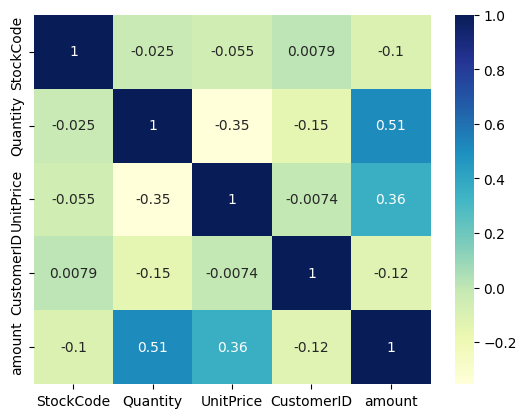

In [17]:
numeric_df = dfv.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

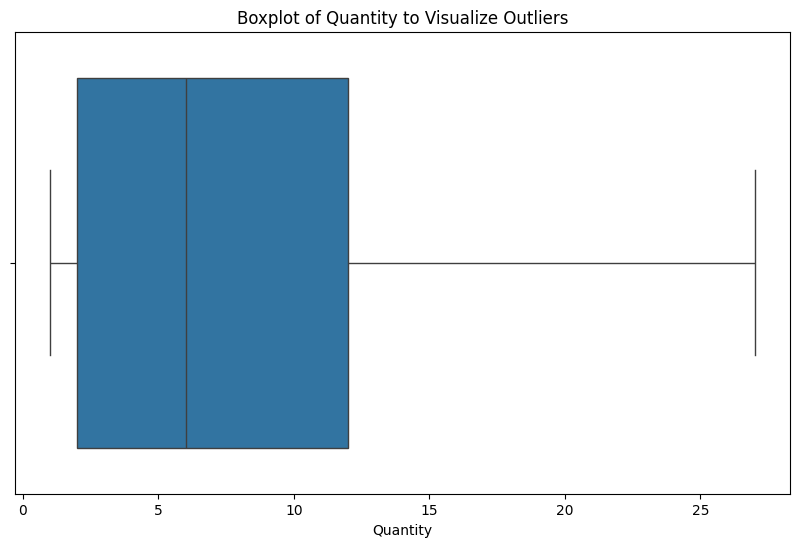

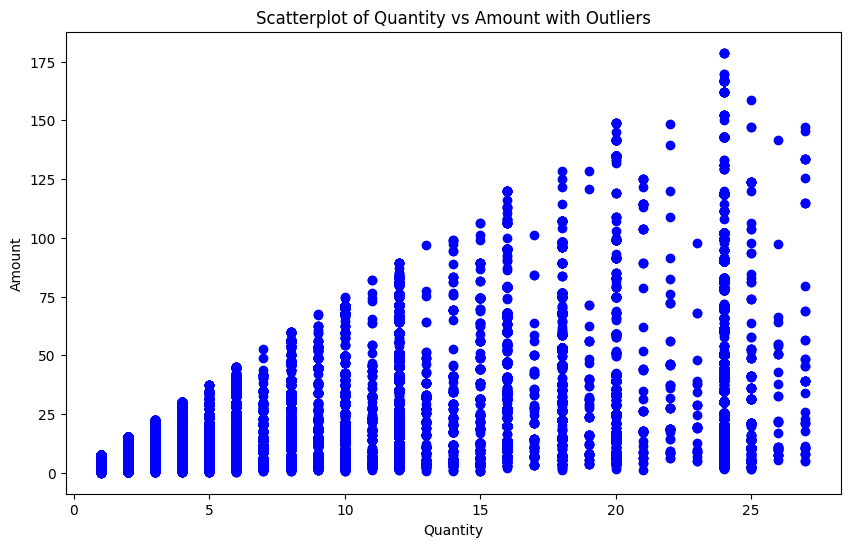

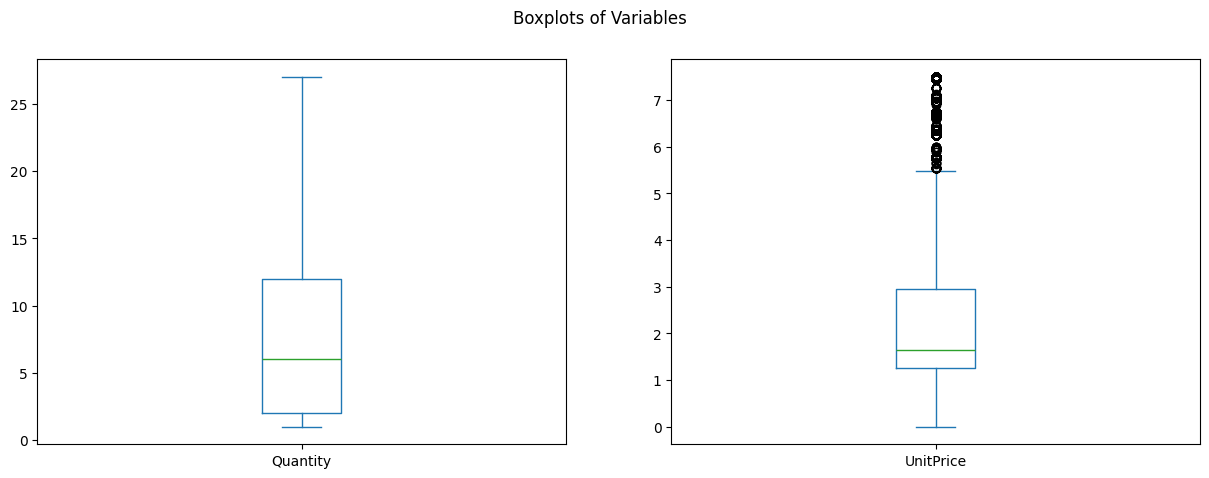

In [18]:


plt.figure(figsize=(10, 6))
sns.boxplot(x=dfv['Quantity'])
plt.title('Boxplot of Quantity to Visualize Outliers')
plt.show()


dfv['Amount'] = dfv['Quantity'] * dfv['UnitPrice']

plt.figure(figsize=(10, 6))
plt.scatter(dfv['Quantity'], dfv['Amount'], color='blue')
plt.title('Scatterplot of Quantity vs Amount with Outliers')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.show()

numerical_cols = ['Quantity', 'UnitPrice']
dfv[numerical_cols].plot(kind='box', subplots=True, layout=(1, len(numerical_cols)), figsize=(15, 5), title='Boxplots of Variables')
plt.show()


As we can see there are a few outliers in the dataset. These outliers affect the model, so we must remove them to get best results.

In [19]:
from scipy import stats

def identify_outliers_iqr(dfv, column):
    Q1 = dfv[column].quantile(0.25)
    Q3 = dfv[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dfv[(dfv[column] < lower_bound) | (dfv[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

quantity_outliers, quantity_lower, quantity_upper = identify_outliers_iqr(dfv, 'Quantity')
unitprice_outliers, unitprice_lower, unitprice_upper = identify_outliers_iqr(dfv, 'UnitPrice')

print("Quantity Outliers:")
print(quantity_outliers)

print("\nUnit Price Outliers:")
print(unitprice_outliers)

print(f"\nQuantity Lower Bound: {quantity_lower}, Upper Bound: {quantity_upper}")
print(f"Unit Price Lower Bound: {unitprice_lower}, Upper Bound: {unitprice_upper}")


Quantity Outliers:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, amount, Amount]
Index: []

Unit Price Outliers:
       InvoiceNo  StockCode                        Description  Quantity  \
14        536367         42           HOME BUILDING BLOCK WORD         3   
15        536367         73           LOVE BUILDING BLOCK WORD         3   
20        536369        365           BATH BUILDING BLOCK WORD         3   
49        536373       2089  WOOD S/3 CABINET ANT WHITE FINISH         4   
64        536375       2089  WOOD S/3 CABINET ANT WHITE FINISH         4   
...          ...        ...                                ...       ...   
328426    581571        436            PARISIENNE KEY CABINET          2   
328521    581580       1931           CINAMMON & ORANGE WREATH         1   
328524    581580        123                      CHILLI LIGHTS         2   
328540    581585        116              LOVE HOT WATER B

In [20]:
def remove_outliers_iqr(dfv, columns):
    dfv_clean = dfv.copy()
    
    for column in columns:
        Q1 = dfv_clean[column].quantile(0.25)
        Q3 = dfv_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        dfv_clean = dfv_clean[(dfv_clean[column] >= lower_bound) & (dfv_clean[column] <= upper_bound)]
    
    return dfv_clean


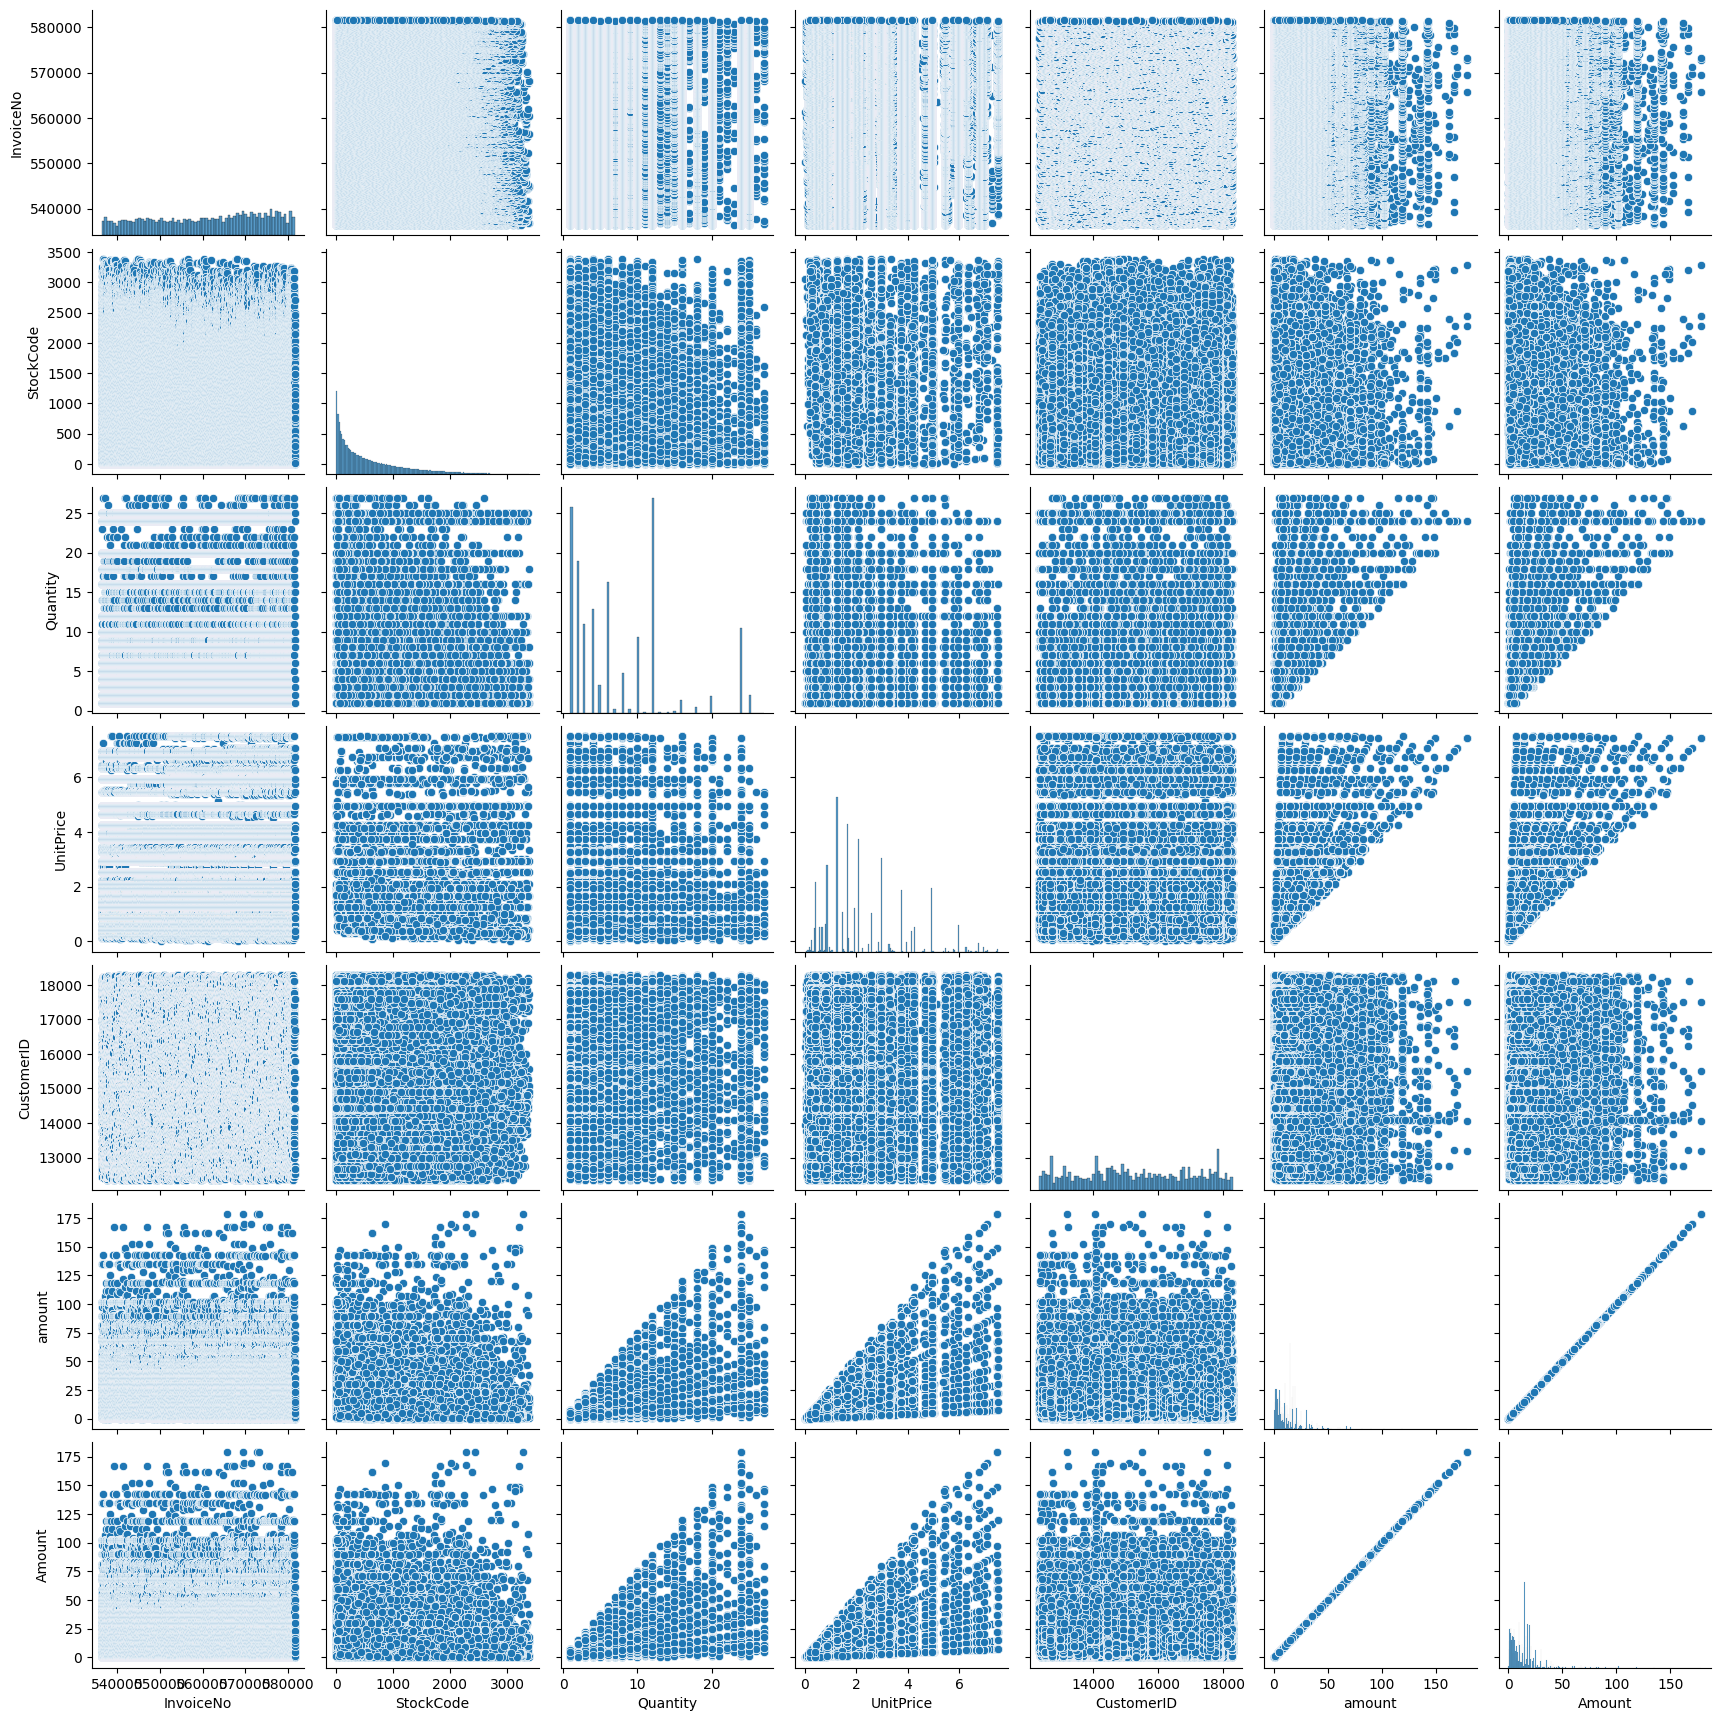

In [21]:
sns.pairplot(dfv)


In [22]:
dfv.describe()

StockCode       Quantity                    InvoiceDate  \
count  328570.000000  328570.000000                         328570   
mean      604.742426       7.607076  2011-07-12 05:33:00.356453376   
min         0.000000       1.000000            2010-12-01 08:26:00   
25%       125.000000       2.000000            2011-04-08 09:08:00   
50%       394.000000       6.000000            2011-08-02 14:04:00   
75%       900.000000      12.000000            2011-10-21 13:17:00   
max      3390.000000      27.000000            2011-12-09 12:50:00   
std       616.911433       6.793858                            NaN   

           UnitPrice     CustomerID         amount         Amount  
count  328570.000000  328570.000000  328570.000000  328570.000000  
mean        2.200160   15312.776988      13.006113      13.006113  
min         0.001000   12347.000000       0.001000       0.001000  
25%         1.250000   13983.000000       4.150000       4.150000  
50%         1.650000   15215.000000      10.200000      10.200000  
75%         2.950000   16813.000000      17.400000      17.400000  
max         7.500000   18287.000000     178.800000     178.800000  
std         1.548492    1711.661677      13.254722      13.254722

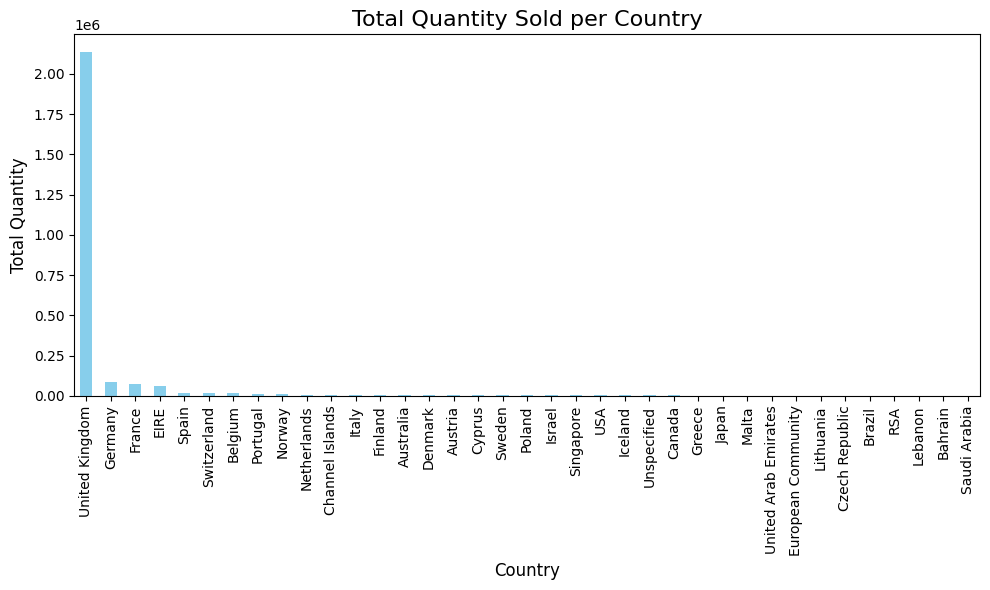

In [23]:
country_quantity = dfv.groupby('Country')['Quantity'].sum().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
country_quantity.plot(kind='bar', color='skyblue')
plt.title('Total Quantity Sold per Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This shows that compared to UK all other countries have very less sales

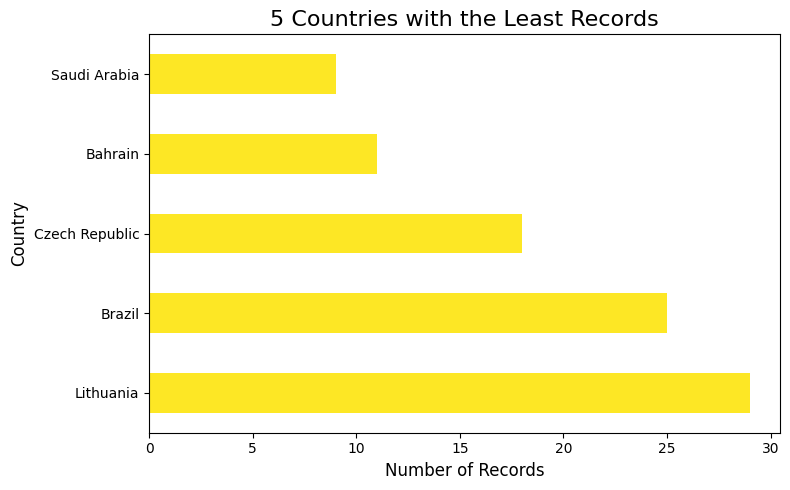

In [24]:
least_common_countries = dfv.Country.value_counts().tail(5)

plt.figure(figsize=(8, 5))
least_common_countries.plot(kind='barh', colormap='viridis_r')
plt.title('5 Countries with the Least Records', fontsize=16)
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

These are the countries with least sales

In [25]:
dfv['year'] = dfv['InvoiceDate'].dt.year
dfv['month'] = dfv['InvoiceDate'].dt.month
dfv['hour'] = dfv['InvoiceDate'].dt.hour
dfv['weekday'] = dfv['InvoiceDate'].dt.day_name()

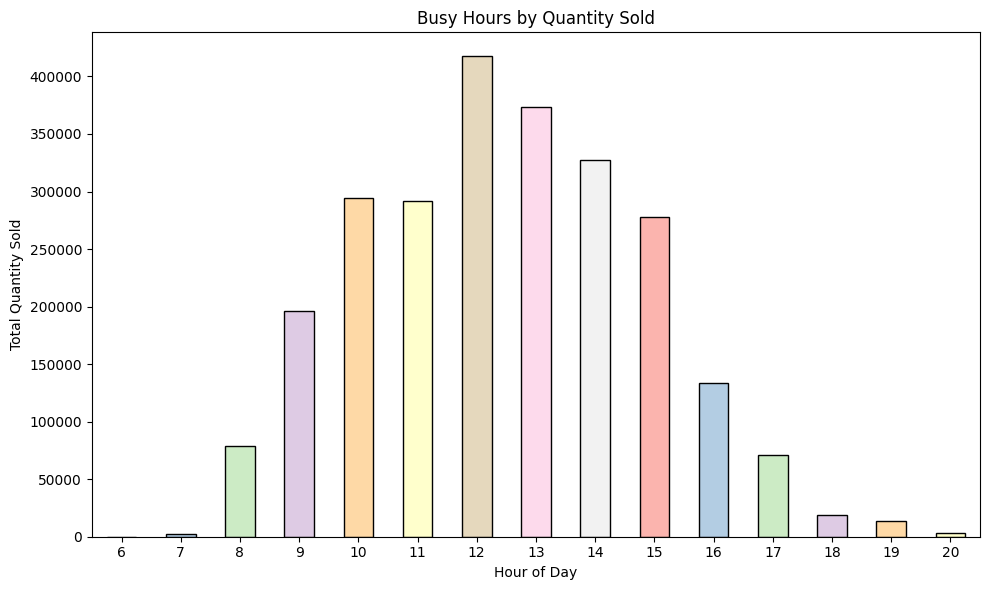

In [26]:
dfv.groupby('hour')['Quantity'].sum().plot(kind='bar', color=plt.cm.Pastel1.colors, figsize=(10, 6), edgecolor='black')
plt.title('Busy Hours by Quantity Sold')
plt.xlabel('Hour of Day')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

This plot shows that afternoons are the busiest times

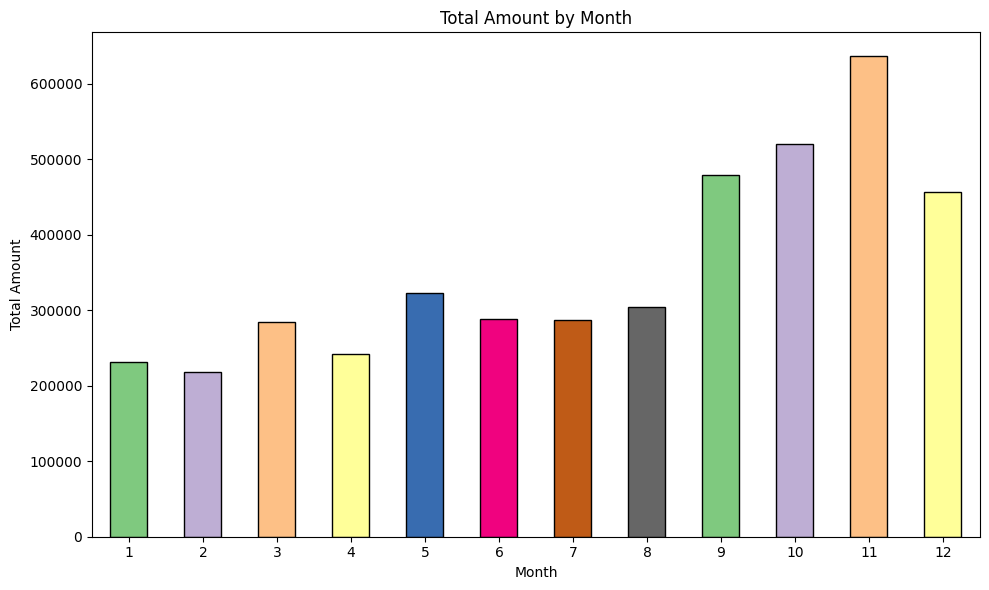

In [27]:
dfv.groupby('month')['amount'].sum().plot(kind='bar', color=plt.cm.Accent.colors, figsize=(10, 6), edgecolor='black')
plt.title('Total Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

This shows that maximum sales have taken place during October-December period

In [28]:
dfv.InvoiceDate.sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
328557   2011-12-09 12:50:00
328556   2011-12-09 12:50:00
328568   2011-12-09 12:50:00
328561   2011-12-09 12:50:00
328569   2011-12-09 12:50:00
Name: InvoiceDate, Length: 328570, dtype: datetime64[ns]

The huge difference between the years is because the dataset starts from december of 2010 and ends in december 2011

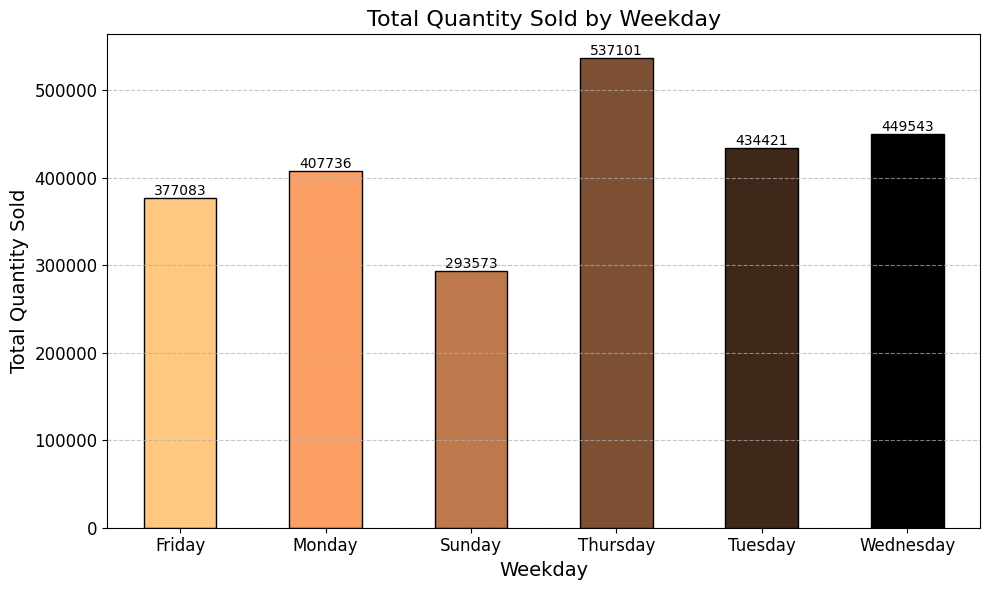

In [29]:


num_bars = dfv['weekday'].nunique()
colors = plt.cm.copper_r(np.linspace(0, 1, num_bars))

plt.figure(figsize=(10, 6))
bars = dfv.groupby('weekday')['Quantity'].sum().plot(kind='bar', color=colors, edgecolor='black')

plt.title('Total Quantity Sold by Weekday', fontsize=16)
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Total Quantity Sold', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Here we can see that no sales happen on Saturday, so the shop must be closed that day and the busiest day is Thursday

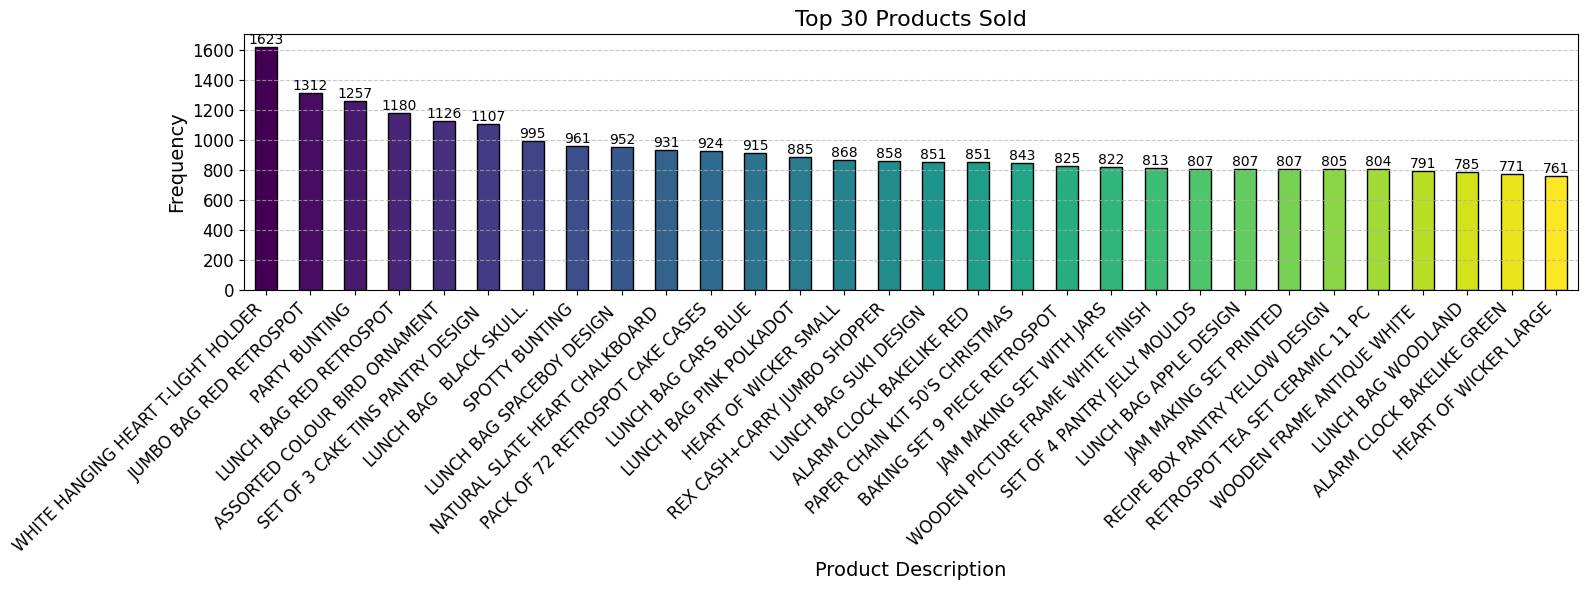

In [30]:
top_products = dfv.Description.value_counts().sort_values(ascending=False)[:30]

plt.figure(figsize=(16, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_products)))
bars = top_products.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Top 30 Products Sold', fontsize=16)
plt.xlabel('Product Description', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


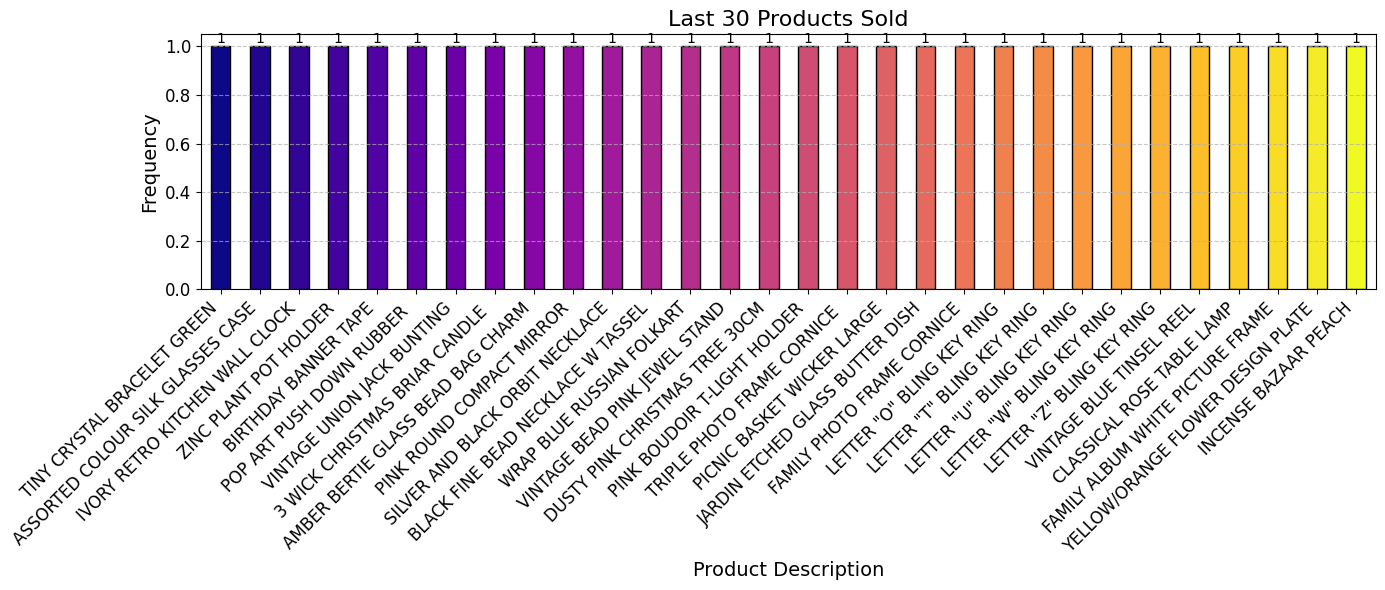

In [31]:
last_products = dfv.Description.value_counts().sort_values(ascending=False)[-30:]

plt.figure(figsize=(14, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(last_products)))
bars = last_products.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Last 30 Products Sold', fontsize=16)
plt.xlabel('Product Description', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Top 20 Customers'}>

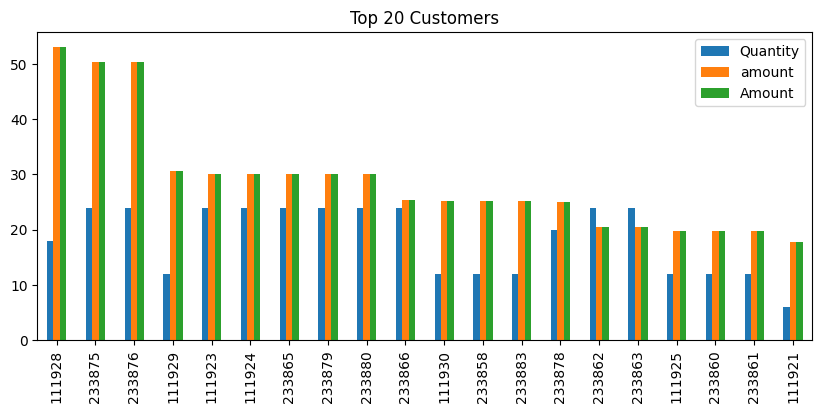

In [32]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[:20].plot(kind='bar', figsize=(10,4), title='Top 20 Customers')

<Axes: title={'center': 'Last 20 Customers'}>

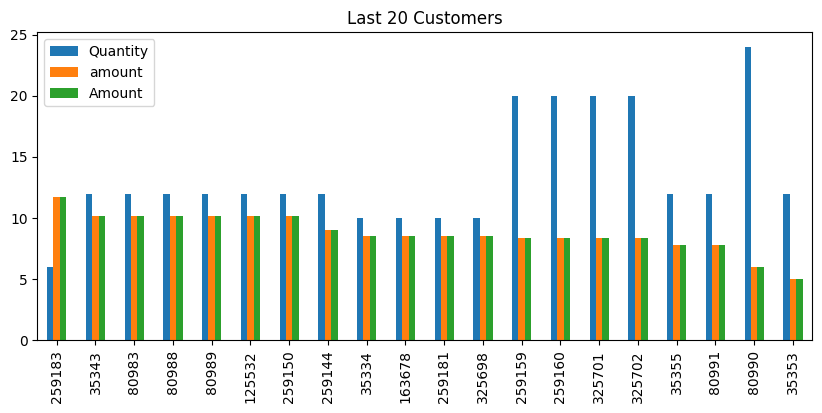

In [33]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[-20:].plot(kind='bar', figsize=(10,4), title='Last 20 Customers')

**RFM Model**

**RFM Model for Customer Value:**
Due to lack of other data columns, we have used a RFM method, *Recency, Frequency and Monetary Value*. It uses customer behaviour for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:



**Recency**: Number of days since last purchase


In [34]:
reference_date = dfv['InvoiceDate'].max() + pd.Timedelta(days=1)
dfv['days_since_last_purchase'] = (reference_date - dfv['InvoiceDate']).dt.days

customer_history_df = (
    dfv.groupby('CustomerID', as_index=False)
    .agg(recency=('days_since_last_purchase', 'min'),
         total_purchases=('InvoiceNo', 'nunique'),
         total_quantity=('Quantity', 'sum'),
         total_spent=('amount', 'sum'))
)

customer_history_df['recency_scaled'] = customer_history_df['recency'] / customer_history_df['recency'].max()

customer_history_df.describe().transpose()
customer_history_df.shape

(4191, 6)

**Frequency**: Total number of transactions

In [35]:
customer_freq = (
    dfv.groupby('CustomerID', as_index=False)
    .agg(frequency=('InvoiceNo', 'nunique'))
)

customer_history_df = customer_history_df.merge(customer_freq, on='CustomerID', how='left')
customer_history_df.describe().transpose()


count          mean          std           min  \
CustomerID       4191.0  15290.900262  1719.057238  12347.000000   
recency          4191.0     92.524219    99.923015      1.000000   
total_purchases  4191.0      4.014316     7.016298      1.000000   
total_quantity   4191.0    596.386781  1250.229661      1.000000   
total_spent      4191.0   1019.665596  2192.387155      1.900000   
recency_scaled   4191.0      0.247391     0.267174      0.002674   
frequency        4191.0      4.014316     7.016298      1.000000   

                          25%           50%           75%       max  
CustomerID       13809.500000  15281.000000  16770.500000  18287.00  
recency             18.000000     51.000000    144.000000    374.00  
total_purchases      1.000000      2.000000      4.000000    196.00  
total_quantity     114.000000    275.000000    678.500000  49386.00  
total_spent        204.195000    462.300000   1121.230000  84980.89  
recency_scaled       0.048128      0.136364      0.385027      1.00  
frequency            1.000000      2.000000      4.000000    196.00


**Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

In [36]:
customer_monetary_val = (
    dfv.groupby('CustomerID', as_index=False)
    .agg(monetary_value=('amount', 'sum'))
)

customer_history_df = customer_history_df.merge(customer_monetary_val, on='CustomerID', how='left')
customer_history_df


CustomerID  recency  total_purchases  total_quantity  total_spent  \
0        12347.0        2                7            1893      3314.73   
1        12348.0      249                3             140        90.20   
2        12349.0       19                1             523       999.15   
3        12350.0      310                1             196       294.40   
4        12352.0       36                7             500      1130.94   
...          ...      ...              ...             ...          ...   
4186     18280.0      278                1              40       137.00   
4187     18281.0      181                1              52        46.92   
4188     18282.0        8                2              51       113.13   
4189     18283.0        4               16            1295      1927.38   
4190     18287.0       43                3             754       921.16   

      recency_scaled  frequency  monetary_value  
0           0.005348          7         3314.73  
1           0.665775          3           90.20  
2           0.050802          1          999.15  
3           0.828877          1          294.40  
4           0.096257          7         1130.94  
...              ...        ...             ...  
4186        0.743316          1          137.00  
4187        0.483957          1           46.92  
4188        0.021390          2          113.13  
4189        0.010695         16         1927.38  
4190        0.114973          3          921.16  

[4191 rows x 8 columns]

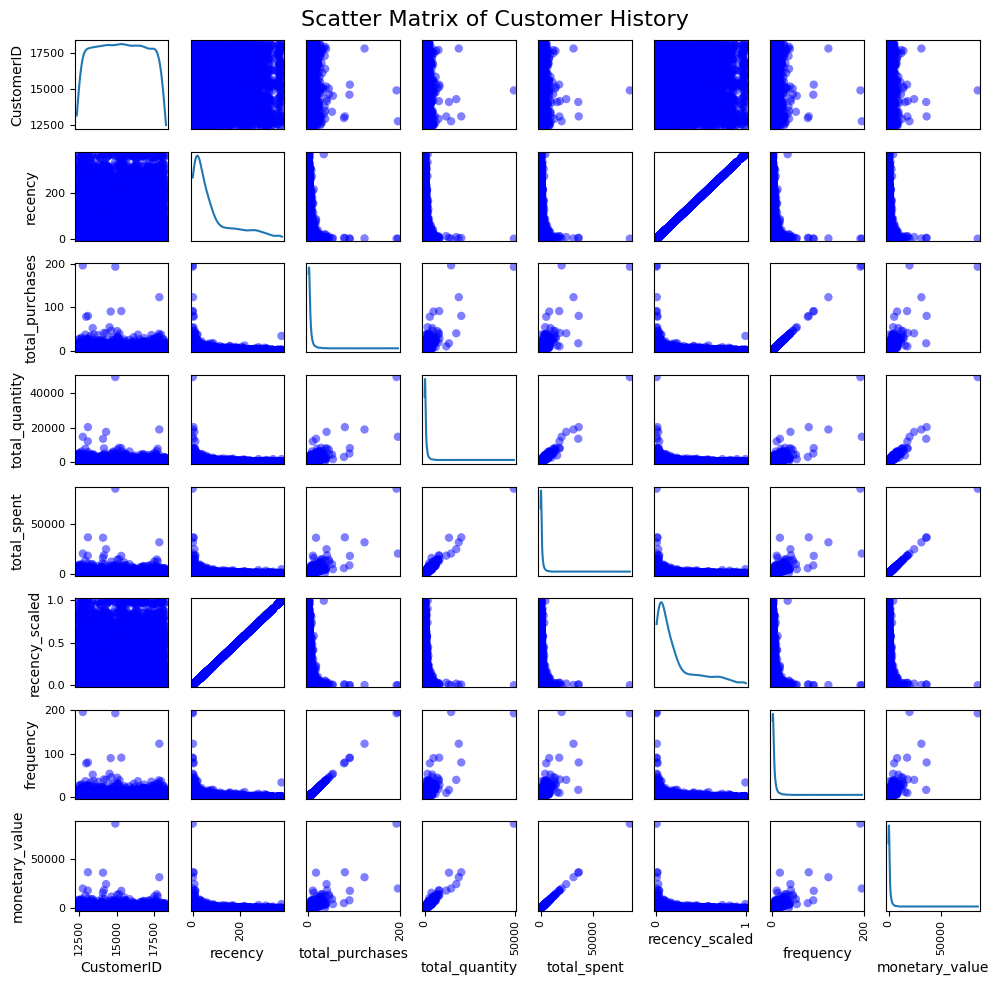

In [37]:


pd.plotting.scatter_matrix(
    customer_history_df,
    alpha=0.5,
    figsize=(10, 10),
    diagonal='kde',
    c='b', 
    marker='o', 
)

plt.suptitle('Scatter Matrix of Customer History', fontsize=16)
plt.tight_layout()
plt.show()


In [38]:
customer_history_df = customer_history_df[~(customer_history_df['recency'] > customer_history_df['recency'].quantile(0.95))]

Normalizing all the values

In [39]:
scaleddata=dfv.copy()

In [40]:
columns_to_scale = ['StockCode', 'UnitPrice', 'Quantity', 'amount', 'InvoiceNo']

for column in columns_to_scale:
    scaleddata[column] = scaleddata[column] / scaleddata[column].abs().max()


In [41]:
import pandas as pd
import datetime

reference_date = dfv['InvoiceDate'].max() + pd.Timedelta(days=1)
dfv['days_since_last_purchase'] = (reference_date - dfv['InvoiceDate']).dt.days

customer_history_df = (
    dfv.groupby('CustomerID', as_index=False)
    .agg(
        recency=('days_since_last_purchase', 'min'),
        frequency=('InvoiceNo', 'nunique'),
        amount=('amount', 'sum')
    )
)

customer_history_df['recency'] = customer_history_df['recency'] / customer_history_df['recency'].abs().max()
customer_history_df['frequency'] = customer_history_df['frequency'] / customer_history_df['frequency'].abs().max()
customer_history_df['amount'] = customer_history_df['amount'] / customer_history_df['amount'].abs().max()



In [42]:
customer_history_df

CustomerID   recency  frequency    amount
0        12347.0  0.005348   0.035714  0.039006
1        12348.0  0.665775   0.015306  0.001061
2        12349.0  0.050802   0.005102  0.011757
3        12350.0  0.828877   0.005102  0.003464
4        12352.0  0.096257   0.035714  0.013308
...          ...       ...        ...       ...
4186     18280.0  0.743316   0.005102  0.001612
4187     18281.0  0.483957   0.005102  0.000552
4188     18282.0  0.021390   0.010204  0.001331
4189     18283.0  0.010695   0.081633  0.022680
4190     18287.0  0.114973   0.015306  0.010840

[4191 rows x 4 columns]

In [43]:
quantiles = customer_history_df.quantile(q=[0.25, 0.5, 0.75])
quantiles.drop('CustomerID', axis=1, inplace=True)


In [44]:
quantiles.to_dict()

{'recency': {0.25: 0.0481283422459893,
  0.5: 0.13636363636363635,
  0.75: 0.3850267379679144},
 'frequency': {0.25: 0.00510204081632653,
  0.5: 0.01020408163265306,
  0.75: 0.02040816326530612},
 'amount': {0.25: 0.002402834331342023,
  0.5: 0.005440046579884019,
  0.75: 0.013193907477316372}}

In [45]:
def score(x, p, d, is_rscore=True):
    if x <= d[p][0.25]:
        return 4 if is_rscore else 1
    elif x <= d[p][0.50]:
        return 3 if is_rscore else 2
    elif x <= d[p][0.75]:
        return 2 if is_rscore else 3
    return 1 if is_rscore else 4

def RScore(x, p, d):
    return score(x, p, d, is_rscore=True)

def FMScore(x, p, d):
    return score(x, p, d, is_rscore=False)


In [46]:
rfm_segmentation = customer_history_df.copy()
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency', quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency', quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['amount'].apply(FMScore, args=('amount', quantiles))


In [47]:
rfm_segmentation.head()

CustomerID   recency  frequency    amount  R_Quartile  F_Quartile  \
0     12347.0  0.005348   0.035714  0.039006           4           4   
1     12348.0  0.665775   0.015306  0.001061           1           3   
2     12349.0  0.050802   0.005102  0.011757           3           1   
3     12350.0  0.828877   0.005102  0.003464           1           1   
4     12352.0  0.096257   0.035714  0.013308           3           4   

   M_Quartile  
0           4  
1           1  
2           3  
3           2  
4           4

In [48]:
rfm_segmentation['RFMScore'] = (
    rfm_segmentation[['R_Quartile', 'F_Quartile', 'M_Quartile']]
    .astype(str)
    .agg(''.join, axis=1)
)

rfm_segmentation.head()


CustomerID   recency  frequency    amount  R_Quartile  F_Quartile  \
0     12347.0  0.005348   0.035714  0.039006           4           4   
1     12348.0  0.665775   0.015306  0.001061           1           3   
2     12349.0  0.050802   0.005102  0.011757           3           1   
3     12350.0  0.828877   0.005102  0.003464           1           1   
4     12352.0  0.096257   0.035714  0.013308           3           4   

   M_Quartile RFMScore  
0           4      444  
1           1      131  
2           3      313  
3           2      112  
4           4      344

In [49]:
top_customers = rfm_segmentation[rfm_segmentation['RFMScore'] == '444'] \
    .sort_values('amount', ascending=False) \
    .head(10)

top_customers


CustomerID   recency  frequency    amount  R_Quartile  F_Quartile  \
1828     14911.0  0.002674   0.984694  1.000000           4           4   
542      13089.0  0.010695   0.408163  0.426779           4           4   
1251     14096.0  0.010695   0.086735  0.421805           4           4   
3885     17841.0  0.005348   0.627551  0.368195           4           4   
1392     14298.0  0.021390   0.204082  0.286977           4           4   
323      12748.0  0.002674   1.000000  0.235247           4           4   
1293     14156.0  0.026738   0.209184  0.215017           4           4   
538      13081.0  0.032086   0.051020  0.210936           4           4   
2113     15311.0  0.002674   0.464286  0.208011           4           4   
1247     14088.0  0.026738   0.061224  0.184755           4           4   

      M_Quartile RFMScore  
1828           4      444  
542            4      444  
1251           4      444  
3885           4      444  
1392           4      444  
323            4      444  
1293           4      444  
538            4      444  
2113           4      444  
1247           4      444

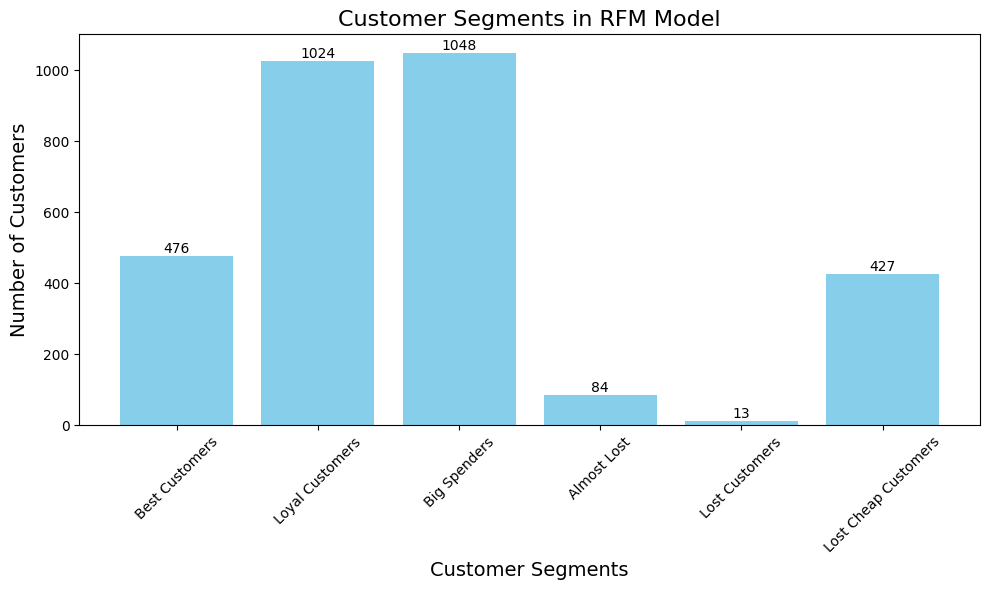

In [50]:

def plot_rfm_segments(rfm_segmentation):
    if not all(col in rfm_segmentation.columns for col in ['RFMScore', 'F_Quartile', 'M_Quartile']):
        raise ValueError("Required columns are missing in the rfm_segmentation DataFrame.")
    
    segment_counts = {
        "Best Customers": (rfm_segmentation['RFMScore'] == '444').sum(),
        "Loyal Customers": (rfm_segmentation['F_Quartile'] == 4).sum(),
        "Big Spenders": (rfm_segmentation['M_Quartile'] == 4).sum(),
        "Almost Lost": (rfm_segmentation['RFMScore'] == '244').sum(),
        "Lost Customers": (rfm_segmentation['RFMScore'] == '144').sum(),
        "Lost Cheap Customers": (rfm_segmentation['RFMScore'] == '111').sum()
    }

    segment_df = pd.DataFrame(segment_counts.items(), columns=['Segment', 'Count'])
    
    plt.figure(figsize=(10, 6))
    plt.bar(segment_df['Segment'], segment_df['Count'], color='skyblue')
    plt.title('Customer Segments in RFM Model', fontsize=16)
    plt.xlabel('Customer Segments', fontsize=14)
    plt.ylabel('Number of Customers', fontsize=14)
    plt.xticks(rotation=45)
    
    for index, value in enumerate(segment_df['Count']):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_rfm_segments(rfm_segmentation)


**`K Means`**

In [51]:
columns_to_drop = ['R_Quartile', 'F_Quartile', 'M_Quartile', 'RFMScore']
customer_history_df.drop(columns=[col for col in columns_to_drop if col in customer_history_df.columns], inplace=True)


In [52]:
customer_history_df

CustomerID   recency  frequency    amount
0        12347.0  0.005348   0.035714  0.039006
1        12348.0  0.665775   0.015306  0.001061
2        12349.0  0.050802   0.005102  0.011757
3        12350.0  0.828877   0.005102  0.003464
4        12352.0  0.096257   0.035714  0.013308
...          ...       ...        ...       ...
4186     18280.0  0.743316   0.005102  0.001612
4187     18281.0  0.483957   0.005102  0.000552
4188     18282.0  0.021390   0.010204  0.001331
4189     18283.0  0.010695   0.081633  0.022680
4190     18287.0  0.114973   0.015306  0.010840

[4191 rows x 4 columns]

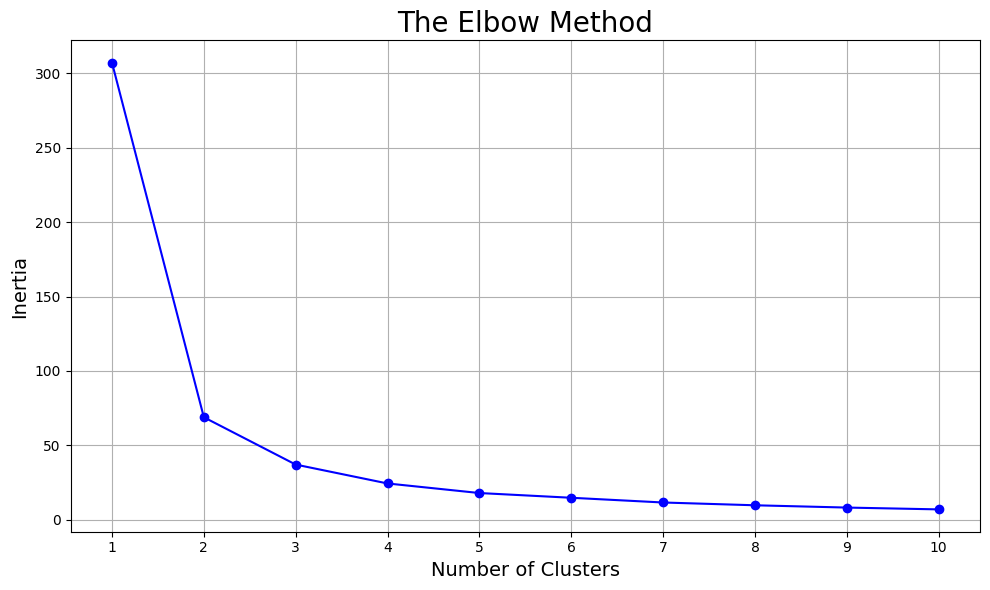

In [53]:


features = customer_history_df[['recency', 'frequency', 'amount']].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(features)
    wcss.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(range(1, 11))
plt.grid()
plt.tight_layout()
plt.show()


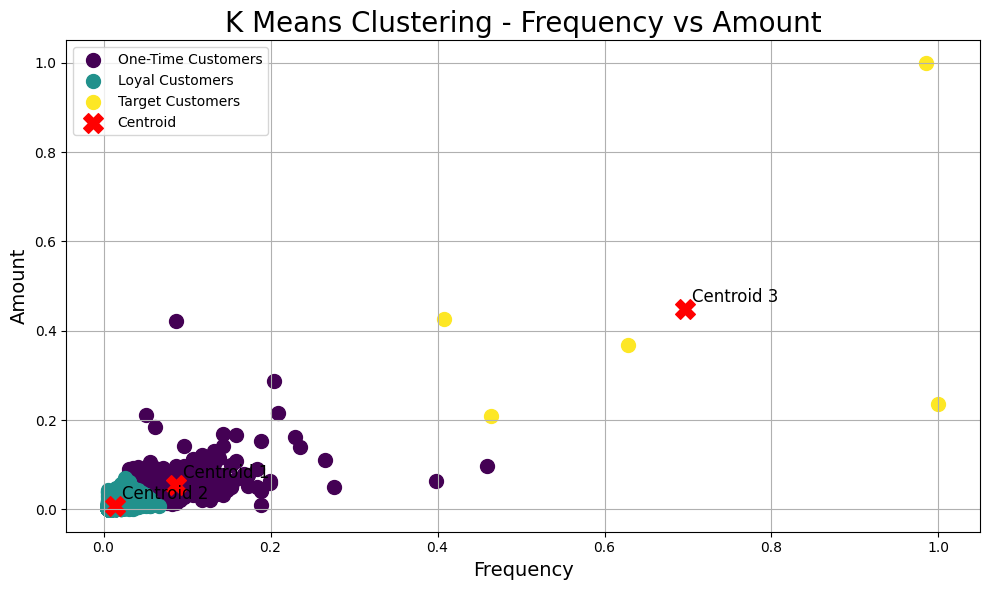

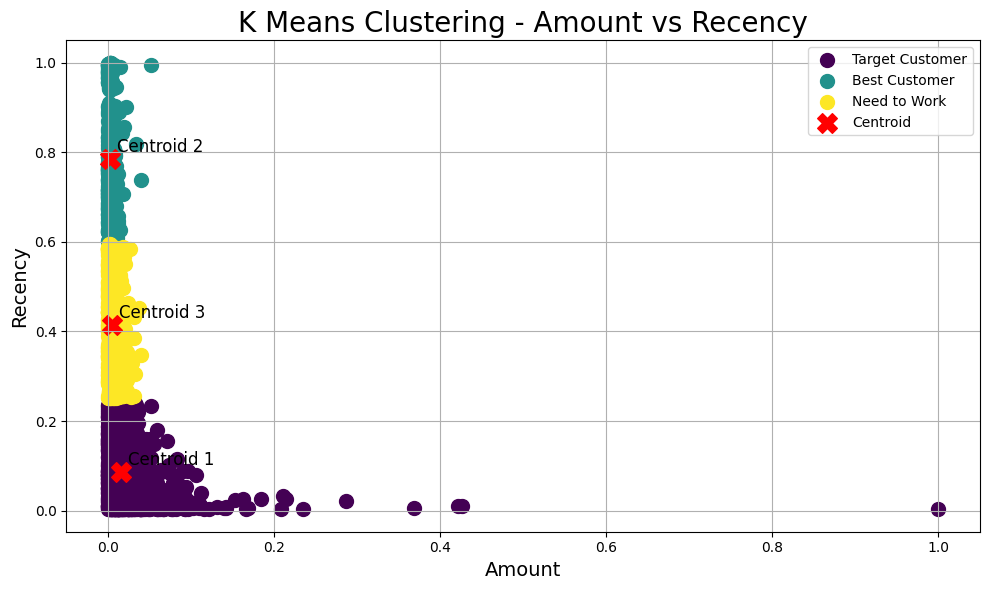

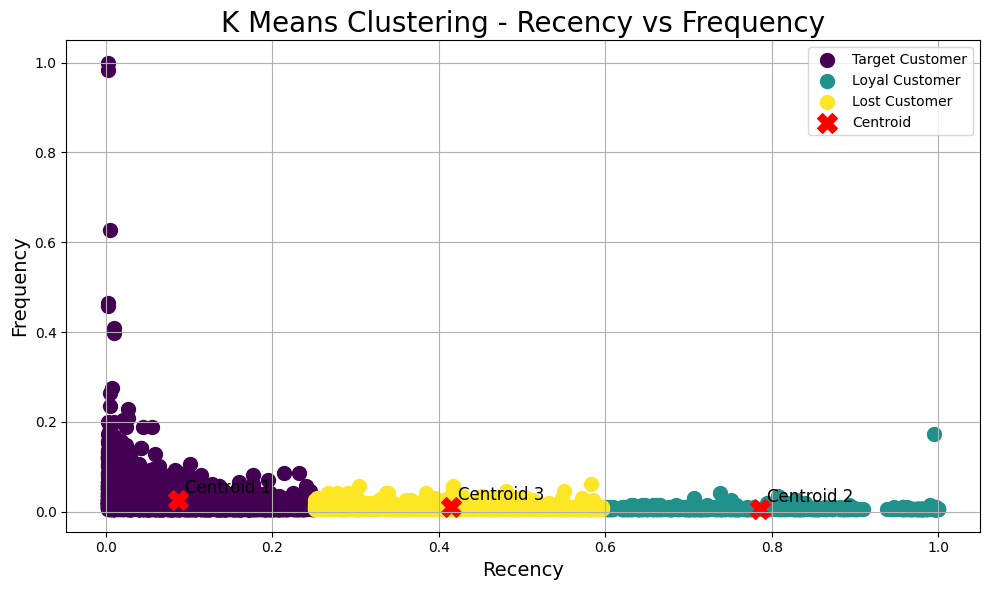

In [54]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

def kmeans_clustering(features, cluster_labels, title, xlabel, ylabel):
    km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_means = km.fit_predict(features)

    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, 3))
    
    for i in range(3):
        plt.scatter(features[y_means == i, 0], features[y_means == i, 1], s=100, color=colors[i], label=cluster_labels[i])

    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=200, color='red', label='Centroid', marker='X')
    
    for i, center in enumerate(km.cluster_centers_):
        plt.annotate(f'Centroid {i+1}', xy=center, xytext=(5, 5), textcoords='offset points', fontsize=12, color='black')

    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


fa = customer_history_df.iloc[:, [2, 3]].values
kmeans_clustering(fa, ['One-Time Customers', 'Loyal Customers', 'Target Customers'], 'K Means Clustering - Frequency vs Amount', 'Frequency', 'Amount')


ar = customer_history_df.iloc[:, [3, 1]].values
kmeans_clustering(ar, ['Target Customer', 'Best Customer', 'Need to Work'], 'K Means Clustering - Amount vs Recency', 'Amount', 'Recency')

rf = customer_history_df.iloc[:, [1, 2]].values
kmeans_clustering(rf, ['Target Customer', 'Loyal Customer', 'Lost Customer'], 'K Means Clustering - Recency vs Frequency', 'Recency', 'Frequency')


**Apriori Algorithm**

In [55]:

from scipy.sparse import csr_matrix

def prepare_basket(df):
    basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
    basket = basket.map(lambda x: 1 if x > 0 else 0)
    return csr_matrix(basket)

def generate_association_rules(basket_sparse, item_names, min_support=0.02, min_confidence=0.3):
    frequent_itemsets = apriori(pd.DataFrame.sparse.from_spmatrix(basket_sparse, columns=item_names), 
                                min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    strong_rules = rules[rules['lift'] > 1].sort_values('lift', ascending=False).head(20)
    return strong_rules

def display_rules(rules, top_n=20):
    print(f"\nStrong Association Rules (Top {top_n}):\n")
    rule_data = []
    for i, rule in rules.iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        rule_data.append([antecedents, consequents, rule['support'], rule['confidence'], rule['lift']])
    
    df_rules = pd.DataFrame(rule_data, columns=["Antecedents", "Consequents", "Support", "Confidence", "Lift"])
    print(df_rules.to_markdown(index=False))



basket_sparse = prepare_basket(dfv)
item_names = dfv['Description'].unique()
strong_rules = generate_association_rules(basket_sparse, item_names)
display_rules(strong_rules, top_n=20)



c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Strong Association Rules (Top 20):

| Antecedents                                                 | Consequents                                                 |   Support |   Confidence |    Lift |
|:------------------------------------------------------------|:------------------------------------------------------------|----------:|-------------:|--------:|
| SILICON CUBE 25W, BLUE                                      | PINK ROUND COMPACT MIRROR, SMALL WHITE/PINK ROSE ART FLOWER | 0.0219924 |     0.552239 | 22.3876 |
| PINK ROUND COMPACT MIRROR, SMALL WHITE/PINK ROSE ART FLOWER | SILICON CUBE 25W, BLUE                                      | 0.0219924 |     0.891566 | 22.3876 |
| SMALL WHITE/PINK ROSE ART FLOWER                            | PINK ROUND COMPACT MIRROR, SILICON CUBE 25W, BLUE           | 0.0219924 |     0.687732 | 22.3799 |
| PINK ROUND COMPACT MIRROR, SILICON CUBE 25W, BLUE           | SMALL WHITE/PINK ROSE ART FLOWER                            | 0.0219924 |     0.7156

**DBSCAN**

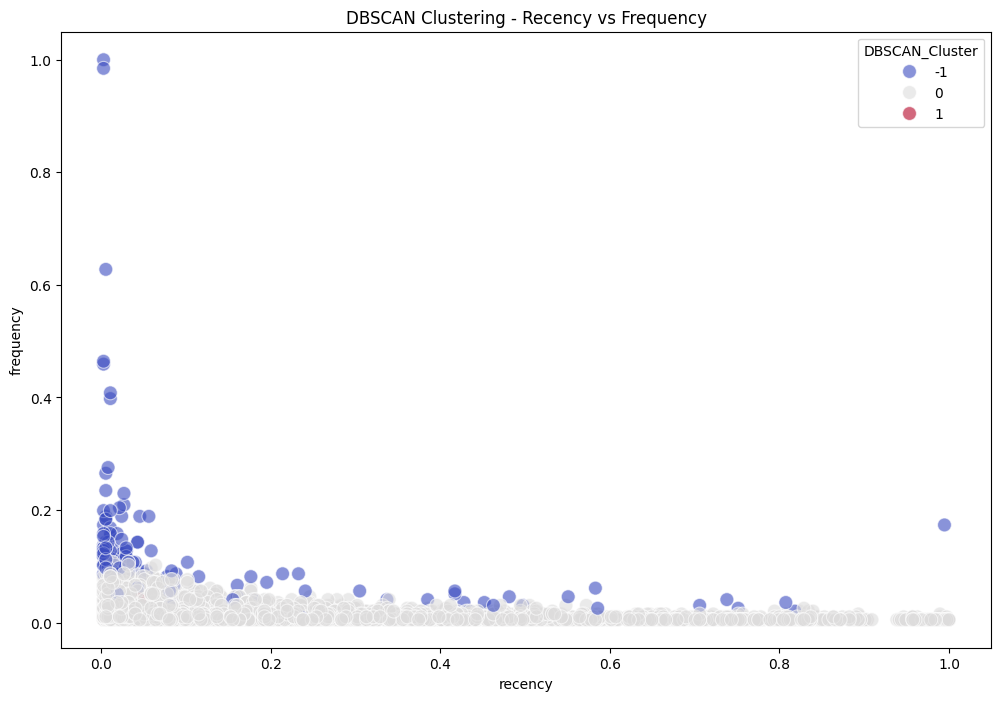

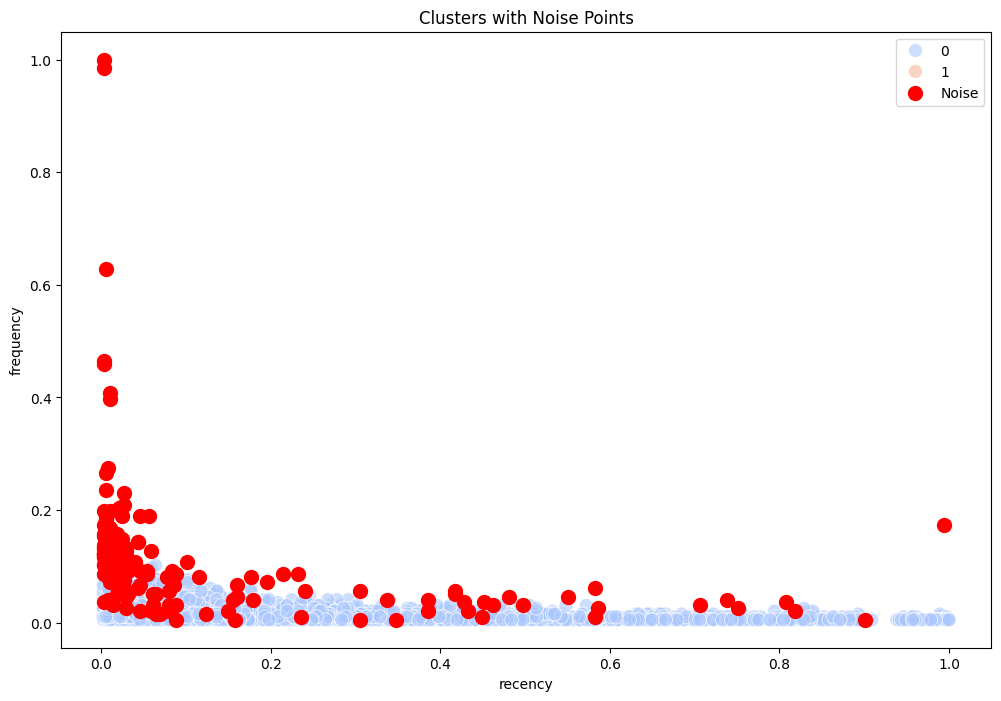

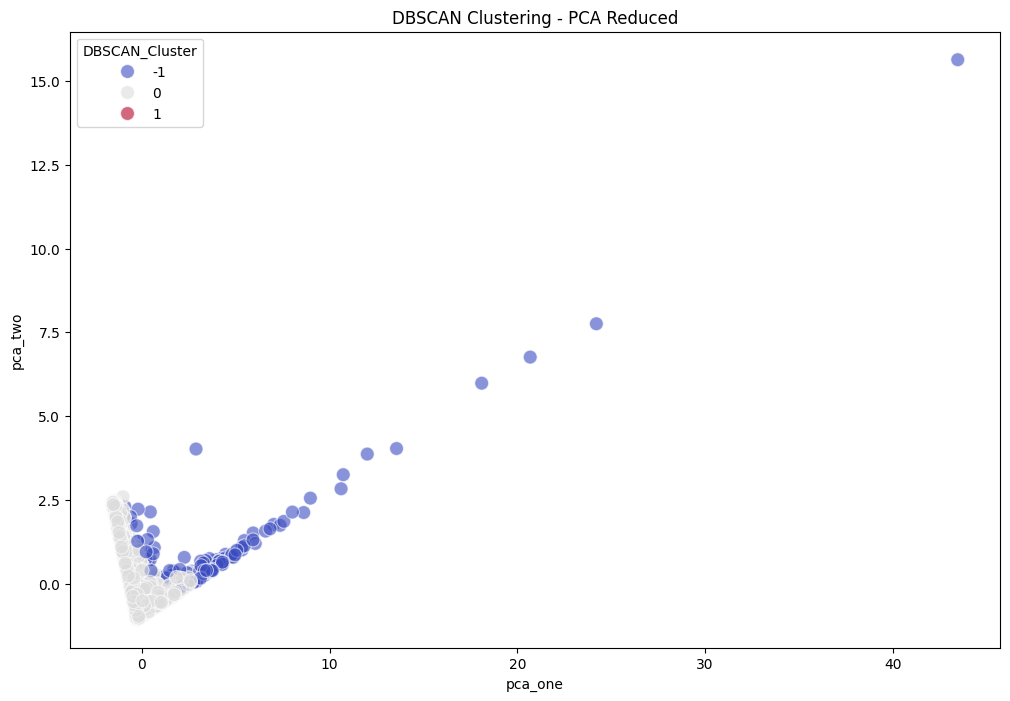

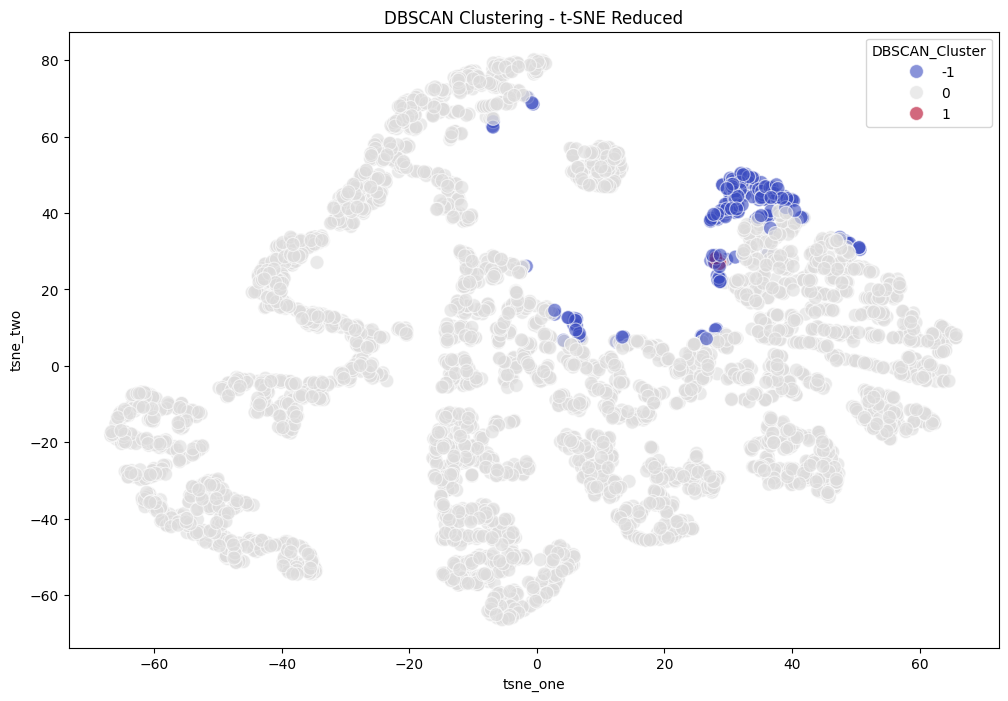

In [56]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

def dbscan_clustering(df, eps=0.5, min_samples=5):
    rfm_df = df[['recency', 'frequency', 'amount']]
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(rfm_scaled)
    df['DBSCAN_Cluster'] = db.labels_
    return df, rfm_scaled

def optimize_dbscan(rfm_scaled):
    param_grid = {'eps': [0.1, 0.2, 0.3, 0.4, 0.5], 'min_samples': [5, 10, 15, 20]}
    dbscan = DBSCAN()
    grid_search = GridSearchCV(dbscan, param_grid, scoring='adjusted_rand_score')
    grid_search.fit(rfm_scaled)
    return grid_search.best_estimator_

def plot_dbscan_clusters(df):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='recency', y='frequency', hue='DBSCAN_Cluster', palette='coolwarm', data=df, s=100, alpha=0.6)
    plt.title('DBSCAN Clustering - Recency vs Frequency')
    plt.show()

    noise = df[df['DBSCAN_Cluster'] == -1]
    clusters = df[df['DBSCAN_Cluster'] != -1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='recency', y='frequency', hue='DBSCAN_Cluster', data=clusters, s=100, alpha=0.6, palette='coolwarm')
    plt.scatter(noise['recency'], noise['frequency'], color='red', label='Noise', s=100)
    plt.legend()
    plt.title('Clusters with Noise Points')
    plt.show()

def reduce_dimensions(df):
    rfm_scaled = StandardScaler().fit_transform(df[['recency', 'frequency', 'amount']])
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(rfm_scaled)
    df['pca_one'] = pca_result[:, 0]
    df['pca_two'] = pca_result[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_one', y='pca_two', hue='DBSCAN_Cluster', palette='coolwarm', data=df, s=100, alpha=0.6)
    plt.title('DBSCAN Clustering - PCA Reduced')
    plt.show()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(rfm_scaled)
    df['tsne_one'] = tsne_result[:, 0]
    df['tsne_two'] = tsne_result[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='tsne_one', y='tsne_two', hue='DBSCAN_Cluster', palette='coolwarm', data=df, s=100, alpha=0.6)
    plt.title('DBSCAN Clustering - t-SNE Reduced')
    plt.show()

def evaluate_dbscan(df, rfm_scaled):
    labels = df['DBSCAN_Cluster']
    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(rfm_scaled, labels)
        print(f'Silhouette Score: {score}')

customer_history_df, rfm_scaled = dbscan_clustering(customer_history_df, eps=0.3, min_samples=10)
plot_dbscan_clusters(customer_history_df)
reduce_dimensions(customer_history_df)
evaluate_dbscan(customer_history_df, rfm_scaled)


c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


| Antecedents                                                      | Consequents                                                      |   Support |   Confidence |    Lift |
|:-----------------------------------------------------------------|:-----------------------------------------------------------------|----------:|-------------:|--------:|
| GREEN REGENCY TEACUP AND SAUCER                                  | PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER  | 0.0219924 |     0.552239 | 22.3876 |
| PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER  | GREEN REGENCY TEACUP AND SAUCER                                  | 0.0219924 |     0.891566 | 22.3876 |
| PINK REGENCY TEACUP AND SAUCER                                   | GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER | 0.0219924 |     0.687732 | 22.3799 |
| GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER | PINK REGENCY TEACUP AND SAUCER                                   |

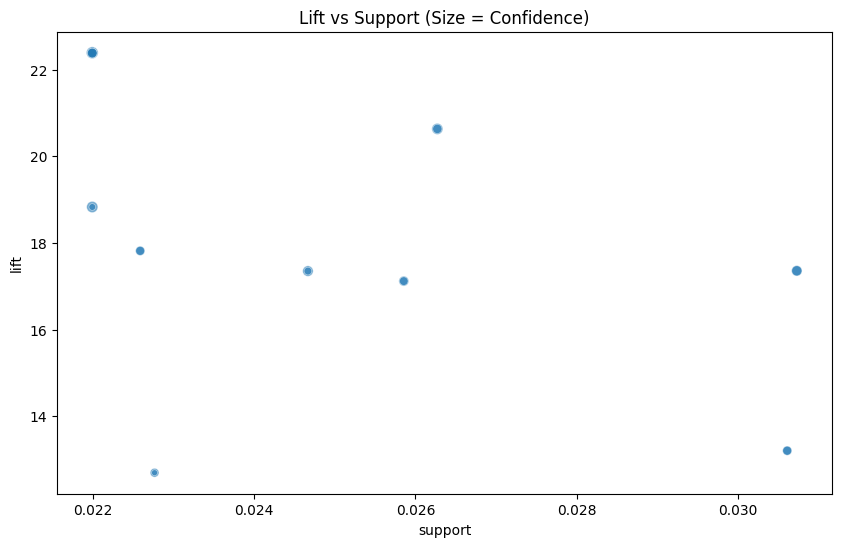

In [57]:
from mlxtend.frequent_patterns import fpgrowth, association_rules


def prepare_basket(df):
    basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
    basket = basket.map(lambda x: 1 if x > 0 else 0)
    return basket

def generate_fp_growth_rules(basket, min_support=0.02, min_confidence=0.3):
    frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    strong_rules = rules[rules['lift'] > 1].sort_values('lift', ascending=False).head(20)
    return strong_rules

def display_rules(rules, top_n=20):
    rule_data = []
    for i, rule in rules.iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        rule_data.append([antecedents, consequents, rule['support'], rule['confidence'], rule['lift']])
    
    df_rules = pd.DataFrame(rule_data, columns=["Antecedents", "Consequents", "Support", "Confidence", "Lift"])
    print(df_rules.to_markdown(index=False))

def plot_lift_vs_support(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='support', y='lift', size='confidence', data=rules, legend=False, alpha=0.6)
    plt.title('Lift vs Support (Size = Confidence)')
    plt.show()

basket = prepare_basket(dfv)
strong_rules = generate_fp_growth_rules(basket)
display_rules(strong_rules, top_n=20)
plot_lift_vs_support(strong_rules)


In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(customer_history_df[['recency', 'frequency', 'amount']], test_size=0.3, random_state=42)

km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_train_pred = km.fit_predict(X_train)
y_test_pred = km.predict(X_test)

train_sil_score = silhouette_score(X_train, y_train_pred)
test_sil_score = silhouette_score(X_test, y_test_pred)

print(f"KMeans Silhouette Score - Train: {train_sil_score}")
print(f"KMeans Silhouette Score - Test: {test_sil_score}")


KMeans Silhouette Score - Train: 0.6474503468093168
KMeans Silhouette Score - Test: 0.6534466224211547


In [59]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(customer_history_df[['recency', 'frequency', 'amount']], test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dbscan = DBSCAN(eps=0.3, min_samples=10)
y_train_pred = dbscan.fit_predict(X_train_scaled)
y_test_pred = dbscan.fit_predict(X_test_scaled)

train_sil_score = silhouette_score(X_train_scaled, y_train_pred)
test_sil_score = silhouette_score(X_test_scaled, y_test_pred)

print(f"DBSCAN Silhouette Score - Train: {train_sil_score}")
print(f"DBSCAN Silhouette Score - Test: {test_sil_score}")


DBSCAN Silhouette Score - Train: 0.6430788112913084
DBSCAN Silhouette Score - Test: 0.5680412930651402


In [64]:

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test = train_test_split(customer_history_df[['recency', 'frequency', 'amount']], test_size=0.3, random_state=42)

km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_train_pred = km.fit_predict(X_train)
y_test_pred = km.predict(X_test)
train_sil_score_kmeans = silhouette_score(X_train, y_train_pred)
test_sil_score_kmeans = silhouette_score(X_test, y_test_pred)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dbscan = DBSCAN(eps=0.3, min_samples=10)
y_train_pred_dbscan = dbscan.fit_predict(X_train_scaled)
y_test_pred_dbscan = dbscan.fit_predict(X_test_scaled)
train_sil_score_dbscan = silhouette_score(X_train_scaled, y_train_pred_dbscan)
test_sil_score_dbscan = silhouette_score(X_test_scaled, y_test_pred_dbscan)

print(f"KMeans Silhouette Score - Train: {train_sil_score_kmeans}")
print(f"KMeans Silhouette Score - Test: {test_sil_score_kmeans}")
print(f"DBSCAN Silhouette Score - Train: {train_sil_score_dbscan}")
print(f"DBSCAN Silhouette Score - Test: {test_sil_score_dbscan}")

def prepare_basket(df):
    basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
    basket_sparse = csr_matrix(basket.applymap(lambda x: 1 if x > 0 else 0))
    return basket_sparse

def generate_apriori_rules(basket_sparse, item_names, min_support=0.02, min_confidence=0.3):
    frequent_itemsets = apriori(pd.DataFrame.sparse.from_spmatrix(basket_sparse, columns=item_names), 
                                min_support=min_support, use_colnames=True, low_memory=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    strong_rules = rules[rules['lift'] > 1].sort_values('lift', ascending=False).head(20)
    return strong_rules

def generate_fp_growth_rules(basket_sparse, item_names, min_support=0.02, min_confidence=0.3):
    frequent_itemsets = fpgrowth(pd.DataFrame.sparse.from_spmatrix(basket_sparse, columns=item_names), 
                                 min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    strong_rules = rules[rules['lift'] > 1].sort_values('lift', ascending=False).head(20)
    return strong_rules

basket_sparse = prepare_basket(dfv)
item_names = dfv['Description'].unique()

apriori_rules = generate_apriori_rules(basket_sparse, item_names)
fp_growth_rules = generate_fp_growth_rules(basket_sparse, item_names)

print(apriori_rules)
print(fp_growth_rules)


KMeans Silhouette Score - Train: 0.6474503468093168
KMeans Silhouette Score - Test: 0.6534466224211547
DBSCAN Silhouette Score - Train: 0.6430788112913084
DBSCAN Silhouette Score - Test: 0.5680412930651402


C:\Users\KIIT\AppData\Local\Temp\ipykernel_6588\408453259.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sparse = csr_matrix(basket.applymap(lambda x: 1 if x > 0 else 0))
c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                          antecedents  \
67                           (SILICON CUBE 25W, BLUE)   
64  (PINK ROUND COMPACT MIRROR, SMALL WHITE/PINK R...   
68                 (SMALL WHITE/PINK ROSE ART FLOWER)   
63  (PINK ROUND COMPACT MIRROR, SILICON CUBE 25W, ...   
9                  (SMALL WHITE/PINK ROSE ART FLOWER)   
8                            (SILICON CUBE 25W, BLUE)   
65  (SILICON CUBE 25W, BLUE, SMALL WHITE/PINK ROSE...   
66                        (PINK ROUND COMPACT MIRROR)   
5                               (SEASIDE FLYING DISC)   
4                           (PINK EASTER HENS+FLOWER)   
10                        (PINK ROUND COMPACT MIRROR)   
11                           (SILICON CUBE 25W, BLUE)   
59                 (SMALL WHITE/PINK ROSE ART FLOWER)   
58                        (PINK ROUND COMPACT MIRROR)   
7                       (BLUE PATCH PURSE PINK HEART)   
6                         (BLUE ROUND COMPACT MIRROR)   
1                  (RETROSPOT H

In [67]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN


scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_history_df[['recency', 'frequency', 'amount']])


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


best_kmeans_score = -1
best_kmeans_params = None
param_grid_kmeans = {'n_clusters': [2, 3, 4, 5, 6], 'n_init': [10, 15, 20], 'max_iter': [300, 500]}

for n_clusters in param_grid_kmeans['n_clusters']:
    for n_init in param_grid_kmeans['n_init']:
        for max_iter in param_grid_kmeans['max_iter']:
            kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, random_state=42)
            kmeans_labels = kmeans.fit_predict(X_pca)
            sil_score = silhouette_score(X_pca, kmeans_labels)
            if sil_score > best_kmeans_score:
                best_kmeans_score = sil_score
                best_kmeans_params = {'n_clusters': n_clusters, 'n_init': n_init, 'max_iter': max_iter}

print(f"Best KMeans Silhouette Score: {best_kmeans_score}")
print(f"Best KMeans Parameters: {best_kmeans_params}")


best_dbscan_score = -1
best_dbscan_params = None
param_grid_dbscan = {'eps': [0.1, 0.2, 0.3, 0.4], 'min_samples': [5, 10, 15, 20]}

for eps in param_grid_dbscan['eps']:
    for min_samples in param_grid_dbscan['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)

        if len(set(dbscan_labels)) > 1:
            sil_score = silhouette_score(X_scaled, dbscan_labels)
            if sil_score > best_dbscan_score:
                best_dbscan_score = sil_score
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best DBSCAN Silhouette Score: {best_dbscan_score}")
print(f"Best DBSCAN Parameters: {best_dbscan_params}")


Best KMeans Silhouette Score: 0.6027989877118848
Best KMeans Parameters: {'n_clusters': 4, 'n_init': 10, 'max_iter': 300}
Best DBSCAN Silhouette Score: 0.7090150499841658
Best DBSCAN Parameters: {'eps': 0.4, 'min_samples': 15}
